# Logistic Regression From Scratch
In this notebook I will be implementing a logistic regression analysis for Kaggle's "Whale categorization playground" competition. This will be the first part in a multi-part
series in which I will use several different machine learning algorithms to perform categorization on the same dataset. Furthermore, in an effort to make sure that I have a deeper understanding of each algorithm I will first be implementing them from scratch followed by using the Scikit-learn package.

When implementing this version of logistic regression I will be using a process adapted from a programming assignment I completed for Andrew Ng's fantastic coursera course "Neural Networks and Deep Learning".

In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
train_labels = pd.read_csv('train.csv')
train_labels.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [3]:
main_dir = %pwd
train_img_fns = glob.glob(main_dir + '/train/*')
n_train = len(train_img_fns)
n_train

9850

In [4]:
def plot_imgs(img_fns, dims, figsize = [16,8]):
    imgs = [np.asarray(Image.open(img_fns[i])) for i in range(len(img_fns))]
    fig=plt.figure(figsize=figsize)
    columns = dims[1]
    rows = dims[0]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])

In [12]:
def process_batch(batch):
    images = [Image.open(image_fn).resize([256,128]) for image_fn in batch]
    images_rgb = [image.convert('RGB') if len(np.asarray(image).shape)<3 else image for image in images] ## converts grayscale images to RGB
    images_arr = np.array([np.asarray(image)/256 for image in images_rgb])
    flat_images = images_arr.reshape(images_arr.shape[0], -1).T
    return flat_images

In [101]:
def batch_gen(data_arr, batch_size = 16, process = True):
    n = 6
    while n < len(data_arr):
        batch = data_arr[n:n+batch_size]
        names = [fn[-12:] for fn in batch]
        if process:
            batch = process_batch(batch)
        yield batch, names
        n = n + batch_size

In [54]:
plot_batches = batch_gen(train_img_fns, process = False)


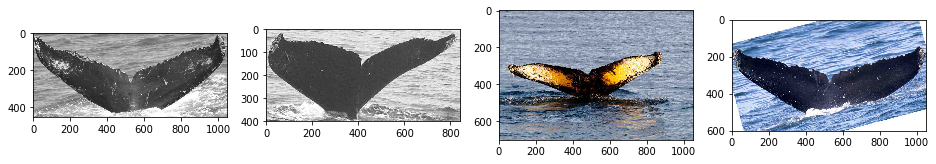

In [55]:
plot_batch, names = next(plot_batches)
plot_imgs(plot_batch[0:5], [1,4])

#### Since there are multiple classes for this dataset I will need to implement 'one vs all' classification. According to kaggle the most challenging part of this competition is limited number of examples (max 34) for each whale species (over 4000). This will likely make logistic regression essentially useless. For now lets classify for one spcies type: 

In [87]:
pos_class = train_labels['Id'].value_counts().keys()[1]
pos_class

'w_1287fbc'

In [91]:
def translate_id(image_names, key_df, pos_class):
    Y_inds = [np.where(key_df['Image'] == name)[0][0] for name in image_names]
    Y = (key_df.loc[Y_inds, 'Id'] == pos_class).as_matrix()*1
    return Y

In [102]:
batches = batch_gen(train_img_fns, batch_size = 64)

In [108]:
batch, batch_names = next(batches)
Y = translate_id(batch_names, train_labels, pos_class)
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [134]:
def init_parameters(x_size):
    W = np.zeros([x_size,1]) #np.random.randn(x_size,1)
    B = np.random.randn(1)
    return [B,W]

In [135]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [136]:
B, W= init_parameters(batch.shape[0])
yhat = sigmoid(np.dot(W.T, batch) + B)

J(θ)=−1N∑i=1Ny(i)log(hθ(x(i)))+(1−y(i))log(1−hθ(x(i)))

In [147]:
(-1/64)*np.add(np.log(yhat), np.multiply((1-Y), np.log(1-yhat)))

array([[0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541, 0.02200541,
        0.02200541, 0.02200541, 0.02200541, 0.02200541]])